In [17]:
import glob
from audioop import cross

import numpy as np
from utils import ProblemInstance, SolverTSP, random_method
from time import time as t
import matplotlib.pyplot as plt

In [18]:
# read all the files that has extention .tsp to the problems array object
problems = glob.glob('./problems/*.tsp')
for prob in problems:
    if prob in ["./problems/eil76.tsp", "./problems/kroA100.tsp"]:
        print(f"- {prob[11:]} with opt", sep='\t')
    else:
        print(f"- {prob[11:]}", sep='\t')

- fl1577.tsp
- lin318.tsp
- kroA100.tsp with opt
- d198.tsp
- pr439.tsp
- rat783.tsp
- eil76.tsp with opt
- u1060.tsp
- ch130.tsp
- pcb442.tsp



#############################

name: eil76
nPoints: 76
best_sol: 538.0
exist optimal: True


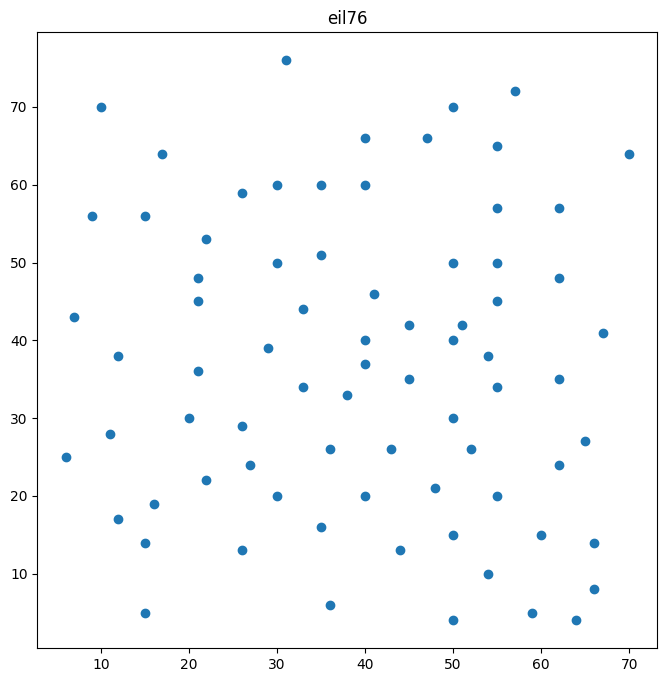

[[ 0. 15. 23. ... 18. 23. 25.]
 [15.  0. 24. ...  7. 12. 15.]
 [23. 24.  0. ... 31. 21. 20.]
 ...
 [18.  7. 31. ...  0. 17. 20.]
 [23. 12. 21. ... 17.  0.  3.]
 [25. 15. 20. ... 20.  3.  0.]]


In [19]:
# example of loading a problem instance
example_problem = "./problems/eil76.tsp"

# create the instance
p_inst = ProblemInstance(example_problem)

# call the implemented methods inside the instance
# print informations about the problem instance
p_inst.print_info()

# plot the instance data points
p_inst.plot_data()

# print the distance matrix computed inside the problem instance
print(p_inst.dist_matrix)

###  solving with random  ####
###  solved  ####


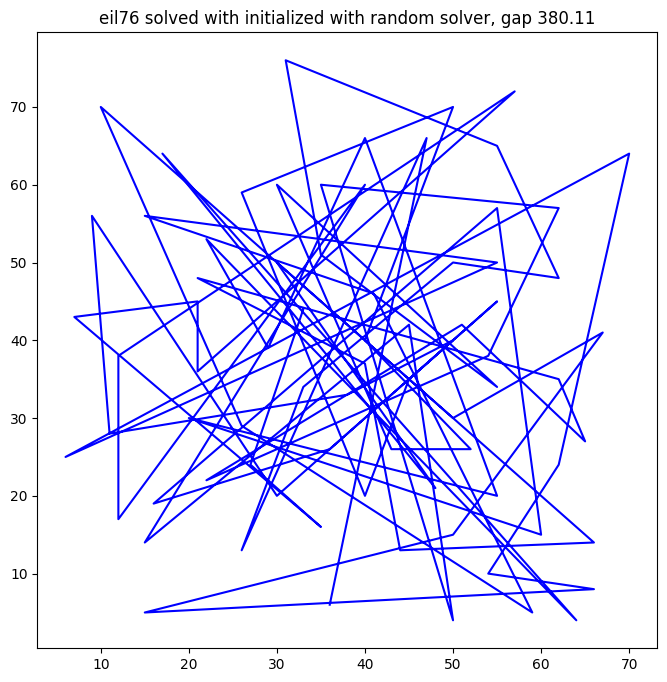

best solution with len 2583.0 
with a total time of 0.00138 seconds


In [20]:
# dictionnary to map a method name to it's implemented function
# this will make it easier to call the corresplonding method inside the TSP solver
# example with random sovler
available_solvers = {"random": random_method}

solver = SolverTSP("random", p_inst, available_solvers)
# start the time counter
start = t()
solver.compute_solution(return_value=False, verbose=True)
# end time counter
end = t()
# plot the solution
solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")

In [21]:
N = p_inst.nPoints  # Total number of unique points, including starting point
matrix = p_inst.dist_matrix  # calculate all distances among all points and create a matrix

In [22]:
# compute the tour length by the help of distance matrix already computed
def evaluate_solution(solution, dist_matrix):
    total_length = 0
    from_node_id = solution[0]  # starting_node

    # loop over all the nodes and add successive distances
    for node_id in solution[1:]:
        edge_distance = dist_matrix[from_node_id, node_id]
        total_length += edge_distance
        from_node_id = node_id

    # have a complete tour and add the distance to go back to starting node
    found_length = total_length + dist_matrix[solution[0], from_node_id]
    return found_length

# Chromosome = Solution = Path
# Chromosome will contain Node list. This will be used in crossover, mutation operations etc,
# Chromosome representation --> chr_representation is only for displaying the route in a simple/clear way
# Chromosome cost will be used to compare the chromosomes
# We want to minimize the cost. So, lower cost is better!
class Chromosome:
    def __init__(self, node_list):
        self.chromosome = node_list
        self.cost = evaluate_solution(node_list, matrix)
        self.fitness_value = 1 / self.cost
        
# create a random chromosome --> shuffle node list randomly
def create_random_list(n_list):
    random.shuffle(n_list) 
    return n_list

# initialization
def initialization(data, pop_size):
    initial_population = []
    for i in range(0, pop_size):  # create chromosomes as much as population size
        temp = create_random_list(data)
        initial_population.append(Chromosome(temp))
    return initial_population

def select_parent(population):  # Tournament-based selection
    # Randomly choose four indices from the population
    indices = random.sample(range(len(population)), 4)

    # Retrieve the chromosomes corresponding to the chosen indices
    chromosomes = [population[i] for i in indices]
       
    # Determine the chromosome with the highest fitness value
    best_candidate = chromosomes[0]
    for chromosome in chromosomes[1:]:
        if chromosome.fitness_value > best_candidate.fitness_value:
            best_candidate = chromosome

    return best_candidate  # Return the fittest chromosome

# Three different crossover methods

# 1 One point crossover
# Method 1: Single-point crossover
def crossover(parent1, parent2):
    # Choose a random crossover point
    crossover_point = random.randint(2, int(len(parent1.chromosome)/4))

    # Split chromosomes at the crossover point
    offspring1_start = parent1.chromosome[:crossover_point]
    offspring2_start = parent2.chromosome[:crossover_point]

    # Ensure unique elements in offspring
    offspring1_remaining = [gene for gene in parent2.chromosome if gene not in offspring1_start]
    offspring2_remaining = [gene for gene in parent1.chromosome if gene not in offspring2_start]

    # Combine segments to form offspring
    offspring1 = list(offspring1_start) + list(offspring1_remaining)
    offspring2 = list(offspring2_start) + list(offspring2_remaining)

    return offspring1, offspring2


# 2 Two points crossover
# Method 2: Two-point crossover
def two_point_crossover(parent1, parent2):
    # Randomly select two crossover points within the chromosome
    point_a, point_b = sorted(random.sample(range(1, len(parent1.chromosome) - 1), 2))

    # Extract the segments between the two points
    segment1 = parent1.chromosome[point_a:point_b + 1]
    segment2 = parent2.chromosome[point_a:point_b + 1]

    # Create the remaining parts of the chromosomes
    remainder1 = [gene for gene in parent2.chromosome if gene not in segment1]
    remainder2 = [gene for gene in parent1.chromosome if gene not in segment2]

    # Combine segments and remainders to form new offspring
    offspring1 = list(segment1) + list(remainder1)
    offspring2 = list(segment2) + list(remainder2)

    return offspring1, offspring2



# 3 Mixed two points crossover
# Method 3: Mixed two-point crossover
def mixed_two_point_crossover(parent1, parent2):
    # Select two random crossover points
    point_a, point_b = sorted(random.sample(range(1, len(parent1.chromosome) - 1), 2))

    # Define segments from the chromosomes
    parent1_prefix = parent1.chromosome[:point_a]
    parent1_suffix = parent1.chromosome[point_b:]
    segment2 = parent2.chromosome[point_a:point_b + 1]

    # Form partial offspring
    partial_offspring1 = list(parent1_prefix) + list(parent1_suffix)
    partial_offspring2 = segment2

    # Add remaining genes while preserving uniqueness
    remainder1 = [gene for gene in parent2.chromosome if gene not in partial_offspring1]
    remainder2 = [gene for gene in parent1.chromosome if gene not in partial_offspring2]

    # Combine to form complete offspring
    offspring1 = list(parent1_prefix) + list(remainder1) + list(parent1_suffix)
    offspring2 = list(partial_offspring2) + list(remainder2)

    return offspring1, offspring2


# Mutation operation
def mutation(chromosome):  # swap two nodes of the chromosome
    mutation_index_1, mutation_index_2 = random.sample(range(1, N-1), 2)
    chromosome[mutation_index_1], chromosome[mutation_index_2] = chromosome[mutation_index_2], chromosome[mutation_index_1]
    return chromosome


# Find the best chromosome of the generation based on the cost
def find_best(generation):
    best = generation[0]
    for n in range(1, len(generation)):
        if generation[n].cost < best.cost:
            best = generation[n]
    return best


# Generate a new population using elitism, crossover, and mutation
def generate_next_population(current_population, mutation_probability,cross_type='single'):
    # Preserve the best individual for elitism
    next_population = [find_best(current_population)]

    # Create offspring for half the population size
    num_pairs = len(current_population) // 2
    for _ in range(num_pairs):
        # Select two parents using the selection method
        parent1 = select_parent(current_population)
        parent2 = select_parent(current_population)

        # Perform crossover to generate offspring
        if cross_type == 'single':
            offspring1_data, offspring2_data = crossover(parent1, parent2)
        elif cross_type == 'two':
            offspring1_data, offspring2_data = two_point_crossover(parent1, parent2)
        else:
            offspring1_data, offspring2_data = mixed_two_point_crossover(parent1, parent2)
            
        offspring1 = Chromosome(offspring1_data)
        offspring2 = Chromosome(offspring2_data)

        # Apply mutation with a given probability
        if random.random() < mutation_probability:
            mutated_data = mutation(offspring1.chromosome)
            offspring1 = Chromosome(mutated_data)

        # Add offspring to the new population
        next_population.append(offspring1)
        next_population.append(offspring2)

    return next_population


0. generation --> cost --> 2229.0
1. generation --> cost --> 2229.0
2. generation --> cost --> 2229.0
3. generation --> cost --> 2229.0
4. generation --> cost --> 2229.0
5. generation --> cost --> 2226.0
6. generation --> cost --> 2200.0
7. generation --> cost --> 2058.0
8. generation --> cost --> 2034.0
9. generation --> cost --> 2015.0
10. generation --> cost --> 1976.0
11. generation --> cost --> 1954.0
12. generation --> cost --> 1888.0
13. generation --> cost --> 1862.0
14. generation --> cost --> 1786.0
15. generation --> cost --> 1786.0
16. generation --> cost --> 1750.0
17. generation --> cost --> 1712.0
18. generation --> cost --> 1711.0
19. generation --> cost --> 1648.0
20. generation --> cost --> 1648.0
21. generation --> cost --> 1635.0
22. generation --> cost --> 1605.0
23. generation --> cost --> 1599.0
24. generation --> cost --> 1584.0
25. generation --> cost --> 1512.0
26. generation --> cost --> 1512.0
27. generation --> cost --> 1509.0
28. generation --> cost --> 14

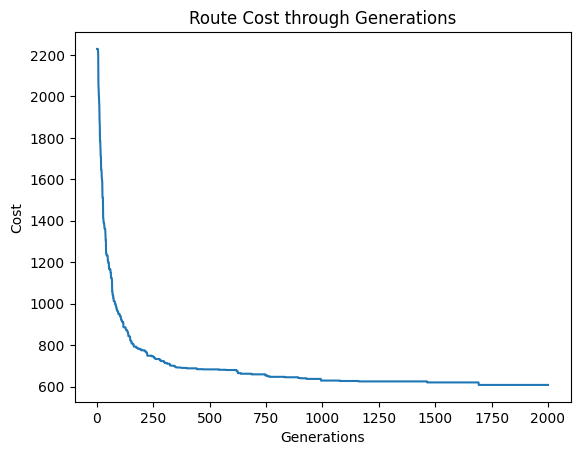

In [24]:
import random
# parameters
numbers_of_generations = 2000  # in other words, iteration size
population_size = 200  # this shows how many solutions will be available in a generation
mut_rate = 0.2  # mutation rate for solution diversity. It should be between 0 and 1. 0.2 means --> 20%

# main function for genetic algorithm
def genetic_algorithm(num_of_generations, pop_size, mutation_rate, data_list):
    new_gen = initialization(data_list, pop_size)  # first generation is created with initialization function

    costs_for_plot = []  # this list is only for Cost-Generations graph. it will constitute y-axis of the graph

    for iteration in range(0, num_of_generations):
        new_gen = generate_next_population(new_gen, mutation_rate,cross_type='mix')  # create a new generation in each iteration
        # print the cost of first chromosome of each new generation to observe the change over generations
        print(str(iteration) + ". generation --> " + "cost --> " + str(new_gen[0].cost))
        costs_for_plot.append(find_best(new_gen).cost)  # append the best chromosome's cost of each new generation
        # to the list to plot in the graph

    return new_gen, costs_for_plot


def draw_cost_generation(y_list):
    x_list = np.arange(1, len(y_list)+1)  # create a numpy list from 1 to the numbers of generation
    plt.plot(x_list, y_list)
    plt.title("Route Cost through Generations")
    plt.xlabel("Generations")
    plt.ylabel("Cost")
    plt.show()


last_generation, y_axis = genetic_algorithm(num_of_generations=numbers_of_generations, pop_size=population_size, mutation_rate=mut_rate, data_list=solver.solution)

best_solution = find_best(last_generation)
draw_cost_generation(y_axis)